In [1]:
import sys, os
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# custom seaborn plot options to make the figures pretty
sns.set(color_codes=True, style='white', context='talk', font_scale=2)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])

sys.path.append(os.path.realpath('..'))

# Independence Power

## vs. Sample Size

Here, we are evaluating the statistical power of each of the independence tests implemented in `hyppo` when increasing the sample size of the 20 independence simulations included in the package. The testing power for a given level of $\alpha$ (Type 1 error level) test is equal to the probability of correctly rejecting the null hypothesis when the alternative is true. For a test to be consistent, statistical power must converge to 1 as the sample size increases to $\infty$.

The following imports from `hyppo` are for all the independence tests, simulations, and the `power_sample` method located within this directory.

In [2]:
from benchmarks import power_sample
from hyppo.independence import *
from hyppo.sims import *

These are some constants that are used in this section of the notebook. If running these notebook, please only manipulate these constants if you are not running more tests.

In [3]:
# sample sizes and number of replications to average over for power curves
MAX_SAMPLE_SIZE = 100
STEP_SIZE = 5
SAMP_SIZES = range(5, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 5

In [4]:
simulations = [
    linear,
    exponential,
    cubic,
    joint_normal,
    step,
    quadratic,
    w_shaped,
    spiral,
    uncorrelated_bernoulli,
    logarithmic,
    fourth_root,
    sin_four_pi,
    sin_sixteen_pi,
    square,
    two_parabolas,
    circle,
    ellipse,
    diamond,
    multiplicative_noise,
    multimodal_independence
]

# add/comment out tests here to run/not run them
tests = [
    MGC,
    CCA,
    Dcorr,
    HHG,
    Hsic,
    Kendall,
    Pearson,
    RV,
    Spearman,
]

The following function calculates the estimated power ``POWER_REPS`` number off times and averages them. It does this iterating over the number of sample sizes.

**Note: We only recommend running this code if running the next 2 cells ONCE to generate the csv files used to visualize the plots. This code takes a very long time to run and if running, we recommend using a machine with many cores.**

In [ ]:
def estimate_power(sim, test):
    est_power = np.array([np.mean([power_sample(test, sim, n=i) for _ in range(POWER_REPS)])
                          for i in SAMP_SIZES])
    np.savetxt('../independence/vs_samplesize/{}_{}.csv'.format(sim.__name__, test.__name__),
               est_power, delimiter=',')
    
    return est_power

In [ ]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim, test) for sim in simulations for test in tests]
)

Here, we plot the results from the power computed from the CSVs in the `vs_sampsize` directory over each of the 20 simulations and for each test run. Using the saved CSVs ensures that the power curves do not have to be run every time the script is run.

In [5]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(28,24))
    
    sim_title = [
        "Linear",
        "Exponential",
        "Cubic",
        "Joint Normal",
        "Step",
        "Quadratic",
        "W-Shaped",
        "Spiral",
        "Bernoulli",
        "Logarithmic",
        "Fourth Root",
        "Sine 4\u03C0",
        "Sine 16\u03C0",
        "Square",
        "Two Parabolas",
        "Circle",
        "Ellipse",
        "Diamond",
        "Multiplicative",
        "Independence"
    ]
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = simulations[count]
            
            for test in tests:
                mgc_power = np.genfromtxt('../independence/vs_samplesize/{}_MGC.csv'.format(sim.__name__),
                                      delimiter=',')
                power = np.genfromtxt('../independence/vs_samplesize/{}_{}.csv'.format(sim.__name__, test.__name__),
                                      delimiter=',')
                
                custom_color = {
                    "Dcorr" : "#377eb8",
                    "Hsic" : "#4daf4a",
                    "MGC" : "#e41a1c",
                }
                if test.__name__ in custom_color.keys():
                    if test.__name__ == "MGC":
                        col.plot(SAMP_SIZES, power - mgc_power, custom_color[test.__name__], label=test.__name__, lw=5)
                    else:
                        col.plot(SAMP_SIZES, power - mgc_power, custom_color[test.__name__], label=test.__name__, lw=3)
                else:
                    col.plot(SAMP_SIZES, power - mgc_power, label=test.__name__, lw=1)
                col.set_xticks([])
                if i == 3:
                    col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
                col.set_ylim(-1.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([-1, 1])
                col.set_title(sim_title[count])
    
    fig.text(0.5, 0.08, 'Sample Size', ha='center')
    fig.text(0.08, 0.5, 'Absolute Statistical Power', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.08), bbox_transform=plt.gcf().transFigure,
                     ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)

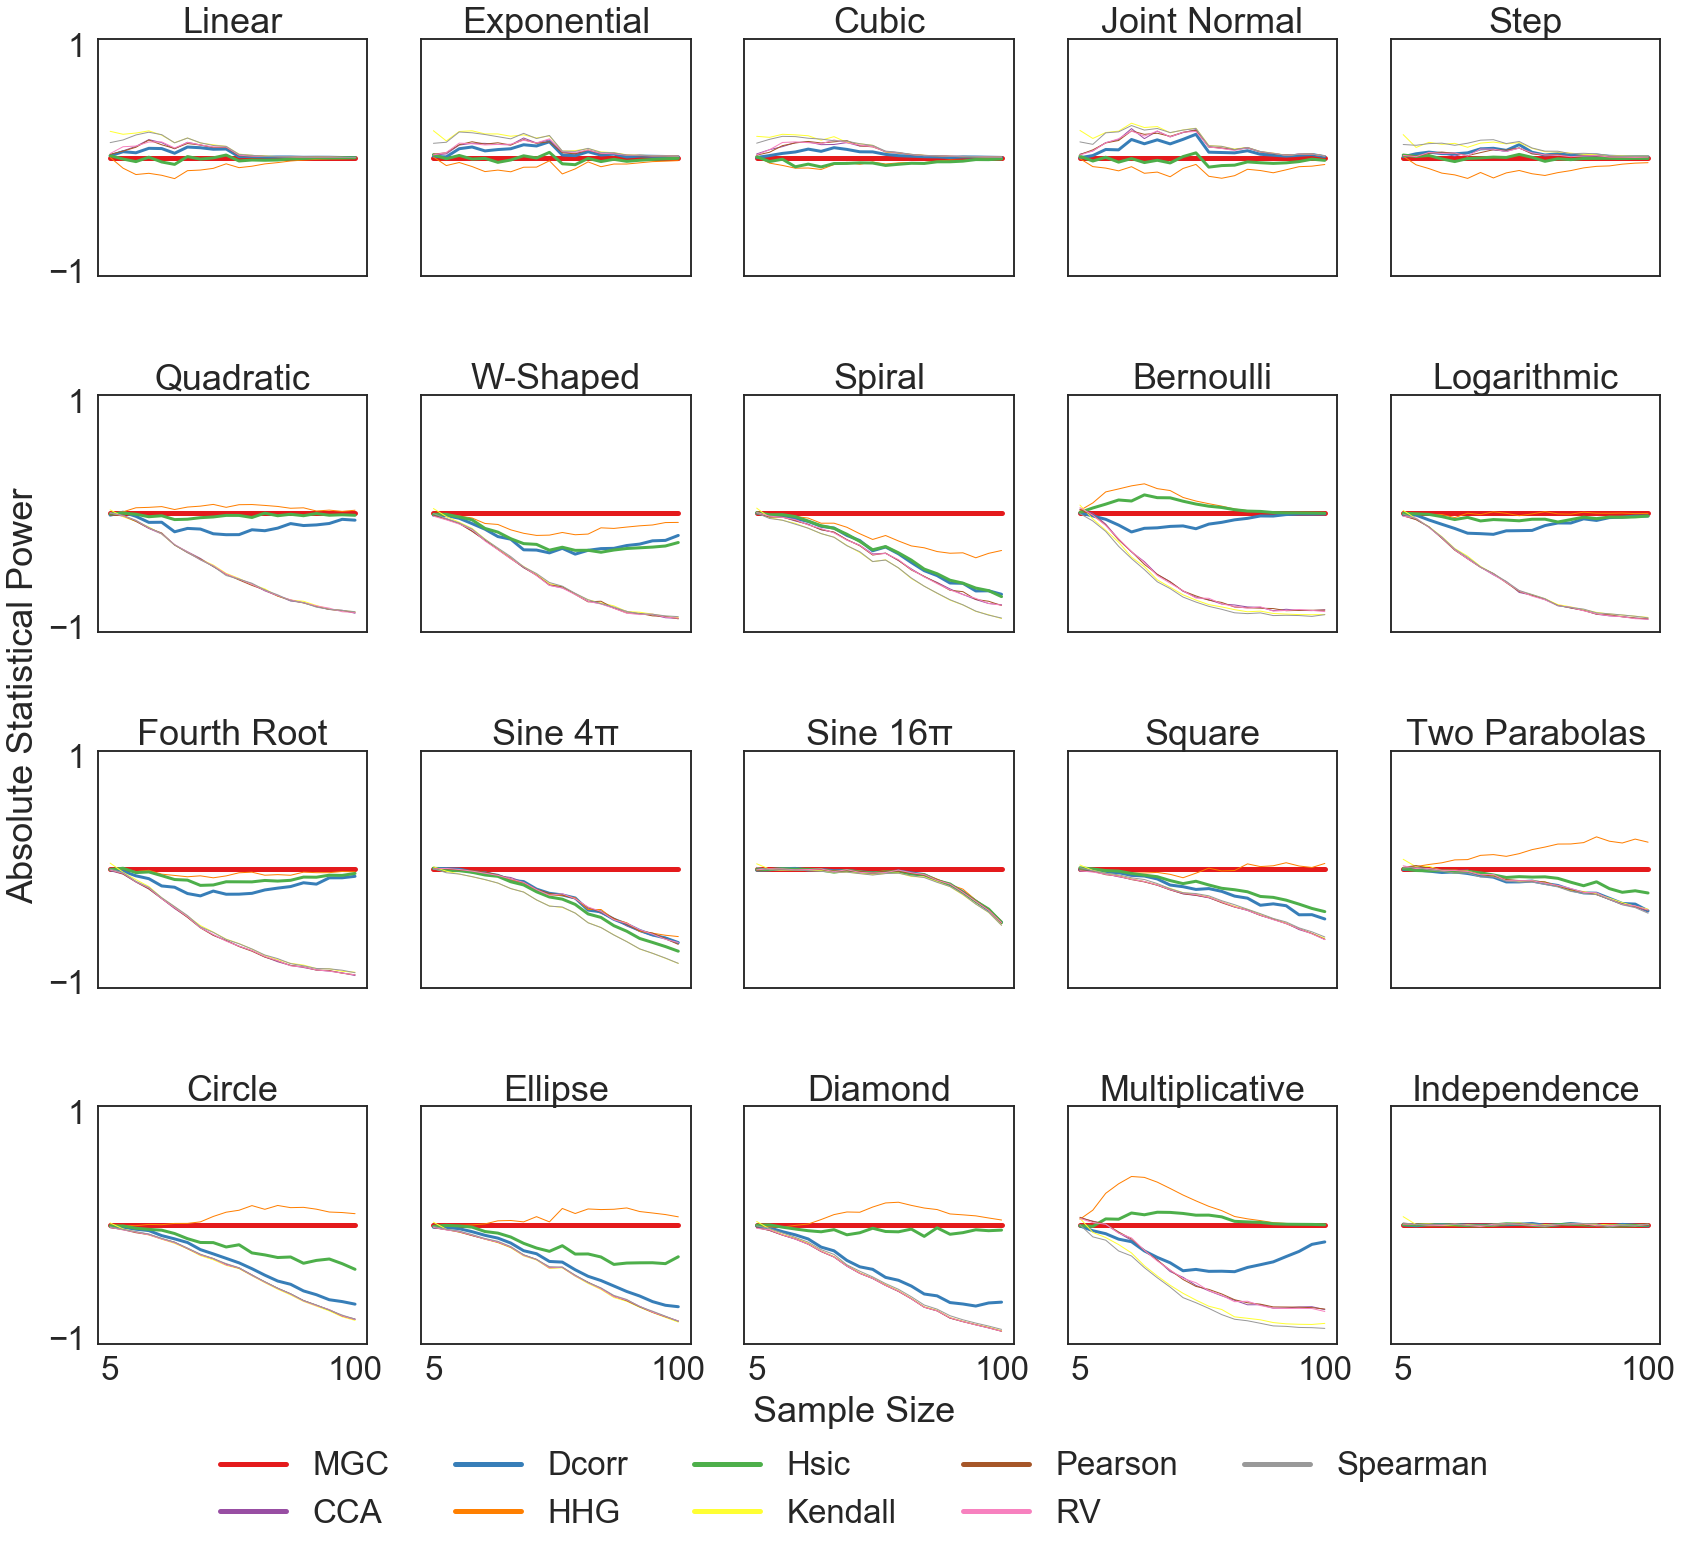

In [6]:
plot_power()

In this figure, thoses tests that have higher statistical power MGC at a given sample size are above the red line, and those that have a lower statistical power than MGC are below it. Here, we see that in most simulation settings, MGC performs as good as or better than many simulations as sample size increases. For some of the more monotonically increasing simulations, some of classical independence tests. HHG outperforms MGC ocassionally with some of the more sinusodially based algorithms, but is much slower to calculate p-values and independence tests.

## vs. Dimension

Here, we are evaluating the statistical power of each of the independence tests implemented in `hyppo` when increasing the dimension of the 20 independence simulations included in the package.

These are some constants that are used in this section of the notebook. If running these notebook, please only manipulate these constants if you are not running more tests.

In [1]:
POWER_REPS = 5

These helper functions return the number of dimensions to test over and the range for each simulation. Limits were chosen based on when it is clear to determine that the tests were tending to 0 statistical power.

In [2]:
def find_dim(sim):
    if sim not in simulations:
        raise ValueError("Invalid simulation")
        
    if sim in [joint_normal, sin_four_pi, sin_sixteen_pi, multiplicative_noise]:
        dim = 10
    elif sim in [multimodal_independence, uncorrelated_bernoulli, logarithmic]:
        dim = 100
    elif sim in [linear, exponential, cubic]:
        dim = 1000
    elif sim in [square, diamond]:
        dim = 40
    else:
        dim = 20
        
    return dim

def find_dim_range(dim):
    if dim < 20:
        lim = 10
    else:
        lim = 20
    
    dim_range = list(range(int(dim/lim), dim+1, int(dim/lim)))
    if int(dim/lim) != 1:
        dim_range.insert(0, 1)
    return dim_range

The following function calculates the estimated power ``POWER_REPS`` number off times and averages them. It does this iterating over the number of dimensions.

**Note: We only recommend running this code if running the next 2 cells ONCE to generate the csv files used to visualize the plots. This code takes a very long time to run and if running, we recommend using a machine with many cores.**

In [ ]:
def estimate_power(sim, test):
    dim = find_dim(sim)
    dim_range = find_dim_range(dim)
    est_power = np.array([np.mean([power_dim(test, sim, p=dim) for _ in range(POWER_REPS)])
                          for dim in dim_range])
    np.savetxt('../independence/vs_dimension/{}_{}.csv'.format(sim.__name__, test.__name__),
               est_power, delimiter=',')
    
    return est_power

In [ ]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim, test) for sim in simulations for test in tests]
)

Here, we plot the results from the power computed from the CSVs in the `vs_dimension` directory over each of the 20 simulations and for each test run. Using the saved CSVs ensures that the power curves do not have to be run every time the script is run.

In [3]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(28,24))
    
    sim_title = [
        "Linear",
        "Exponential",
        "Cubic",
        "Joint Normal",
        "Step",
        "Quadratic",
        "W-Shaped",
        "Spiral",
        "Bernoulli",
        "Logarithmic",
        "Fourth Root",
        "Sine 4\u03C0",
        "Sine 16\u03C0",
        "Square",
        "Two Parabolas",
        "Circle",
        "Ellipse",
        "Diamond",
        "Multiplicative",
        "Independence"
    ]
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = simulations[count]
            
            for test in tests:
                power = np.genfromtxt('../benchmarks/vs_dimension/{}_{}.csv'.format(sim.__name__, test.__name__),
                                      delimiter=',')
                dim_range = find_dim_range(find_dim(sim))
                
                custom_color = {
                    "Dcorr" : "b",
                    "Hsic" : "g"
                }
                if test.__name__ in custom_color.keys():
                    if test.__name__ not in ["MGC", "MGCRF"]:
                        col.plot(dim_range, power, custom_color[test.__name__], label=test.__name__, lw=5)
                    else:
                        col.plot(dim_range, power, custom_color[test.__name__], label=test.__name__, lw=2)
                else:
                    col.plot(dim_range, power, label=test.__name__, lw=1)
                col.set_xticks([dim_range[0], dim_range[-1]])
                col.set_ylim(0, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([0, 1])
                col.set_title(sim_title[count])
    
    fig.text(0.5, 0.08, 'Dimensions', ha='center')
    fig.text(0.08, 0.5, 'Absolute Statistical Power', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.08), bbox_transform=plt.gcf().transFigure,
                     ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)

In [ ]:
plot_power()